In [32]:
# !pip install treys
# !pip install termcolor
# !pip install pandas

In [ ]:
from treys import card
from termcolor import colored
from utils import eval_listof_games, debug_listof_games, save_results, load_results

In [3]:
import PIL.Image
import numpy as np
from typing import Union, List
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.fft import fft
from scipy.interpolate import interp1d

from skimage.transform import rotate
from skimage.morphology import binary_erosion, dilation, opening, closing, disk
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import median
from skimage.measure import find_contours
import cv2

import utils_finals
import importlib
importlib.reload(utils_finals)

# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 29.04.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)

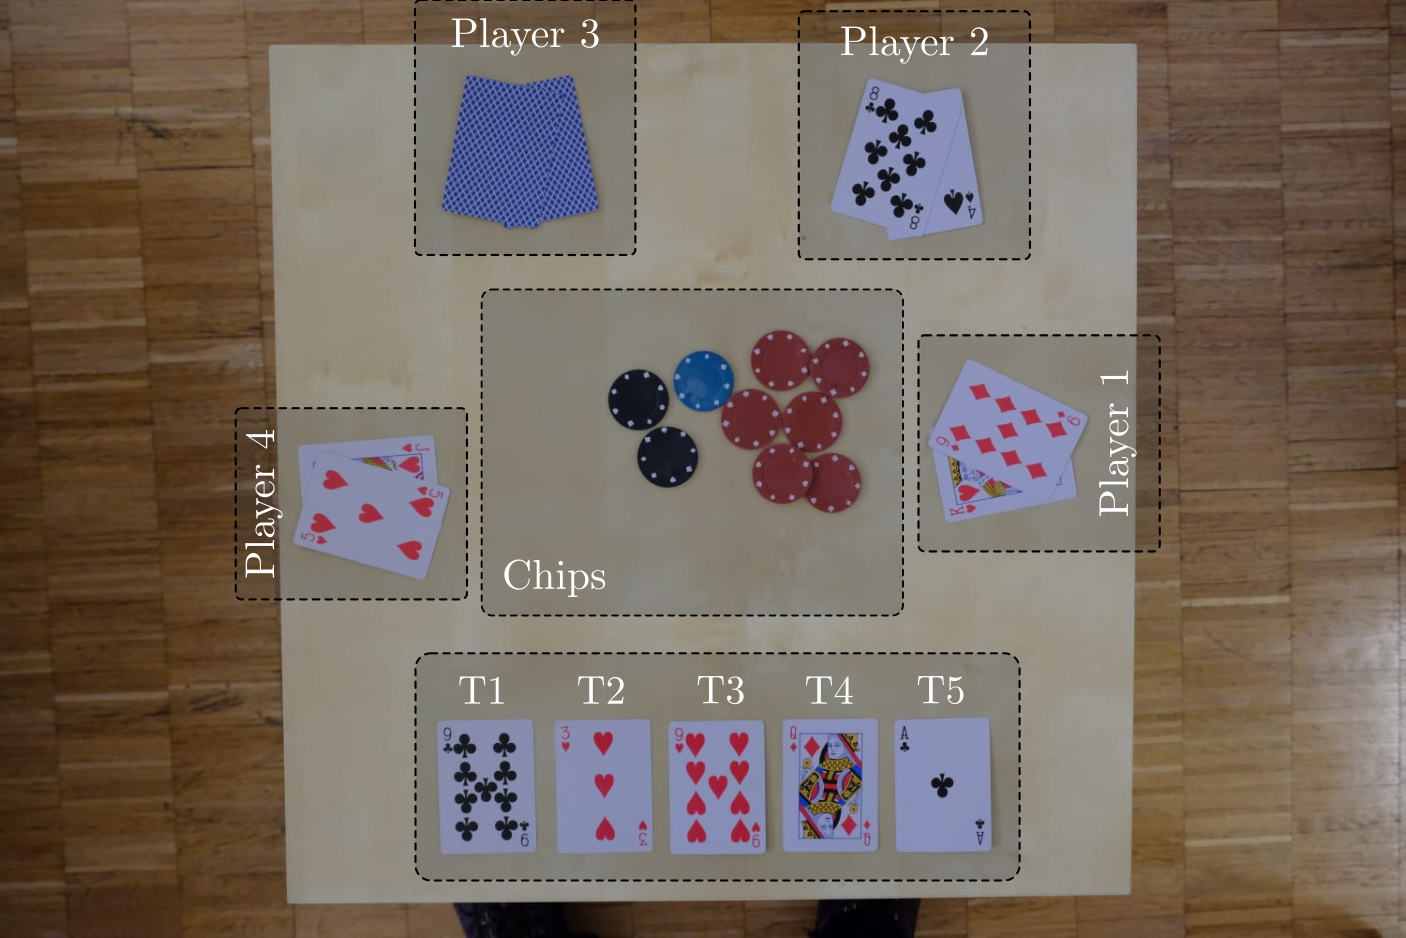


### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing and (A)ce.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)

```
data 
│
└─── image_setup
│    │    back_cards.jpg      # Back of the cards (either blue or red)
│    │    chips.jpg           # Set of chips used (red, green, blue, black, white)
│    │    kings.jpg           # Kings from the 4 colors (diamond, heart, spade, club)
│    │    spades_suits.jpg    # All cards of spades (2 - 10, Jack, Queen, King, Ace)
│    │    table.jpg           # Empty table
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---
## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

In [176]:
def process_image(image) -> dict:
    """
    Process image and return information. To return the value of the cards we use 
    the following format: {number}{color}. Where 
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(ce).
            
    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left) 
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot
        
    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """
    
    # TODO: Amazing student code
    
    dummy_results = {
        # Flop, river and turn
        "T1": "2C", "T2": "AH", "T3": "8D", "T4": "JC", "T5": "JS",
        # Player cards
        "P11": '2H' , "P12": '3C', "P21": 'KS', "P22": "QS", "P31": "KD", "P32":"5S" , "P41": "7H", "P42": "8H",
        # Chips
         "CR": 1, "CG": 1, "CB": 1,"CK": 5, "CW": 0
    }
    return dummy_results


Working example

In [35]:
## load train size dataset
path_data = os.path.join("data", "train")
group_id = 0

In [36]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate three images
games_id = [0,3]  # to evaluate  three images

for i in games_id :
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    results = process_image(image=im)
    # Append result to array
    game_results[i] = results

# Outputs prediction of game 0
print("Prediciton game:\n\t{}: {}".format(0, game_results[0]))

Size of trainset:
	28
Prediciton game:
	0: {'T1': '2C', 'T2': 'AH', 'T3': '8D', 'T4': 'JC', 'T5': 'JS', 'P11': '2H', 'P12': '3C', 'P21': 'KS', 'P22': 'QS', 'P31': 'KD', 'P32': '5S', 'P41': '7H', 'P42': '8H', 'CR': 1, 'CG': 1, 'CB': 1, 'CK': 5, 'CW': 0}


<module 'chris_utils' from 'C:\\Users\\Jan Warhuus\\Desktop\\EPFL\\EE451\\Iapr_final_project\\chris_utils.py'>

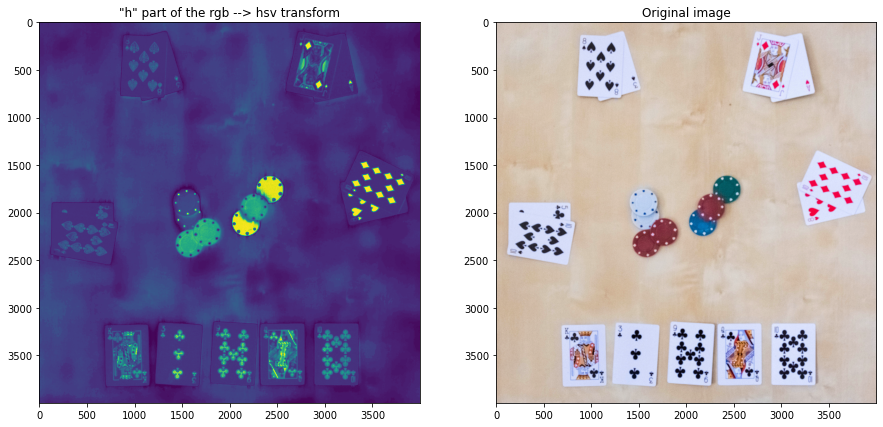

In [254]:
all_imgs, hsv_imgs = utils_finals.load_and_process_full_image(4)

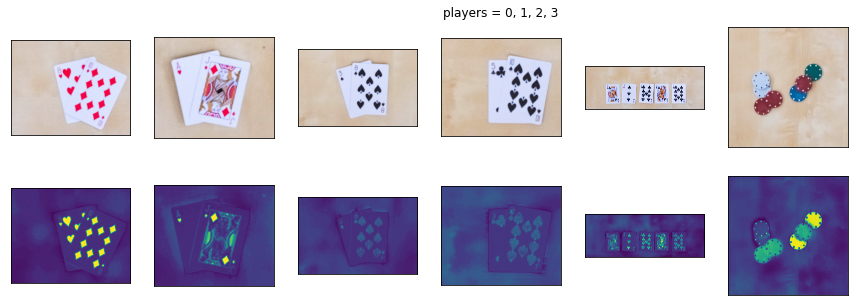

In [255]:
players, imgs, h_imgs = utils_finals.get_players_and_imgs(hsv_imgs, all_imgs)

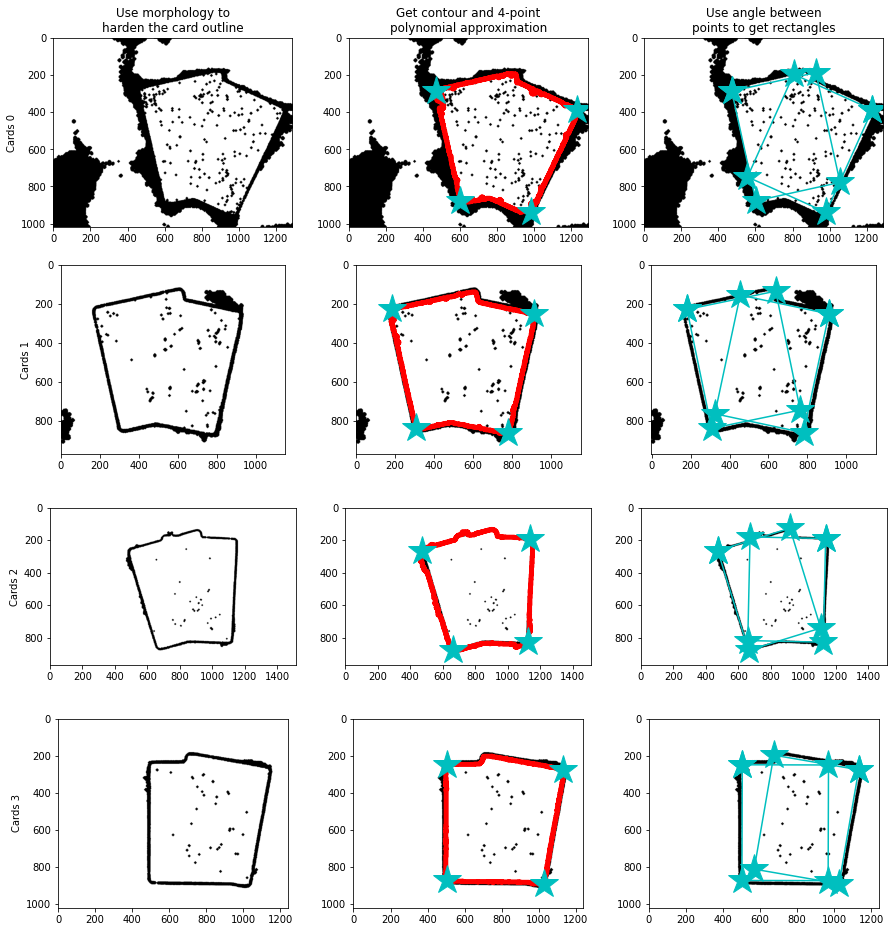

In [256]:
card_outlines = utils_finals.segment_cards(imgs, h_imgs)

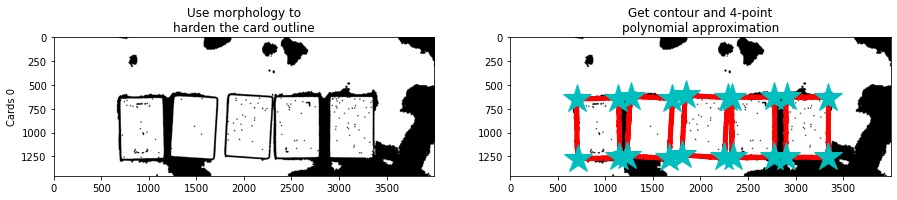

In [273]:
importlib.reload(utils_finals)
table_outlines = utils_finals.segment_cards([table], [h_table], make_plot=True, table_imgs=True)

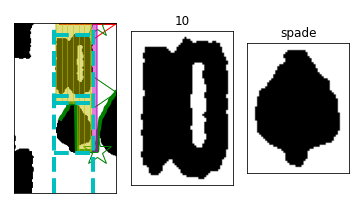

In [274]:
with open('numbers.pickle', 'rb') as handle:
    real_numbers = pickle.load(handle)
    
with open('suits.pickle', 'rb') as handle:
    real_suits = pickle.load(handle)

nums, types = utils_finals.get_numbers_and_suits(card_outlines, imgs, real_numbers, real_suits)

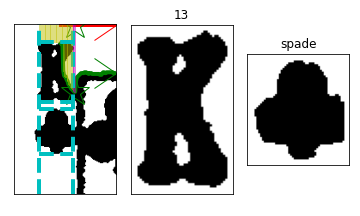

In [275]:
nums, types = utils_finals.get_numbers_and_suits(table_outlines, [table], real_numbers, real_suits, table_cards=True)

# Evaluation and Debugging

In [23]:
# Read training data
game_labels = pd.read_csv('data/train/train_labels.csv')
game_labels = game_labels.fillna('0')
game_labels

,Image,T1,T2,T3,T4,T5,P1.1,P1.2,P2.1,P2.2,P3.1,P3.2,P4.1,P4.2,R,G,B,K,W
0,Train_00,2C,6H,8D,JC,JS,2H,4S,KS,QS,KD,5S,7H,8H,1,1,1,1,1
1,Train_01,9H,8C,2H,4C,JS,0,0,3C,KH,KD,2D,QS,3S,2,0,1,0,1
2,Train_02,9D,3D,4C,6D,2H,7H,QD,10S,10C,5C,4S,2S,4H,0,0,8,1,0
3,Train_03,6D,KH,7H,KC,6H,QC,QS,3C,3D,4H,5D,2S,7C,0,2,4,0,0
4,Train_04,KC,3C,9C,QC,10C,8H,10D,AH,JD,3S,8S,5C,10S,3,1,1,0,2
5,Train_05,8H,6D,4C,7D,AC,3D,KS,9D,6S,0,0,7H,7C,2,1,2,1,0
6,Train_06,QS,5S,KS,KD,8C,0,0,6H,7D,8D,2C,JC,JD,1,0,0,0,0
7,Train_07,7C,AD,6C,KH,9D,2D,9H,0,0,0,0,4H,5D,1,0,1,2,0
8,Train_08,9C,4C,QC,7D,JD,QD,4D,9C,10C,9D,3C,5D,KC,0,0,0,0,0
9,Train_09,8H,6D,4C,7D,AC,3D,KS,9D,6S,0,0,7H,7C,2,1,2,1,0


In [24]:
# Evaluate
eval_listof_games( game_results , game_labels , game_id = games_id)

Game 0 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]


             	scores
Card number 	0.85 %
Card suit   	0.92 %
Chips       	0.17 %


FINAL score 	0.65 %
________________________________________
Game 3 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['6D' 'KH' '7H' 'KC' '6H' 'QC' 'QS' '3C' '3D' '4H' '5D' '2S' '7C' 0 2 4 0
 0]


             	scores
Card number 	0.08 %
Card suit   	0.15 %
Chips       	0.0 %


FINAL score 	0.08 %
________________________________________
Average SCORE =  0.36111111111111116


0.36111111111111116

In [25]:
# Debug
debug_listof_games( game_results , game_labels, game_id = games_id)

Game 0 results
Estimated game
['2C', 'AH', '8D', 'JC', 'JS', '2H', '3C', 'KS', 'QS', 'KD', '5S', '7H', '8H', 1, 1, 1, 5, 0]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]




NameError: name 'Card' is not defined